# Reforge — Thesis Headline Figures

> **Abstract:** This thesis presents Reforge, a six-stage deterministic pipeline for constructing
> high-confidence ground truth from stripped binaries for evaluating large language models on
> reverse engineering tasks. The pipeline's confidence funnel achieves 87% yield at no optimization
> but drops to 66% at O3, revealing that binary-source alignment is the primary bottleneck for
> LLM evaluation in this domain. Evaluation of seven LLMs on function naming shows modest accuracy
> (mean Token F1 ≈ 0.25) with no robust paired optimization-induced decay (all Holm-corrected
> p ≥ 0.209) and meaningful benefit from top-3 candidate shortlists (13.6%–26.7% of functions
> improved).

**Experimental matrix:** 7 models × 3 confidence tiers × 4 optimization levels × top-k=3 → 84 experiments, ~4,837 scored predictions.

| # | Figure | Key Finding |
|---|--------|-------------|
| 1 | Confidence Funnel | Binary-source alignment is the hard problem — HC yield drops from 87% to 66% |
| 2 | Model Ranking Box Plot | LLM naming accuracy is modest (mean F1 ≈ 0.25, median = 0.0 for 6/7 models) |
| 3 | Optimization Decay Heatmap | Paired O0→O3 decay: all Holm-corrected p ≥ 0.209, not significant |
| 4 | Tier Transition Matrices | 40% of functions are lost between O0 and O3 through inlining/elimination |
| 5 | Top-K Uplift ECDF | Top-3 shortlists improve 13.6%–26.7% of predictions |

---

In [1]:
# ══════════════════════════════════════════════════════════════════════════════
# §0  Setup — Imports, Constants, Helpers
# ══════════════════════════════════════════════════════════════════════════════
from __future__ import annotations

import json
import sys
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# ── Path resolution ──────────────────────────────────────────────────────────
# Notebook lives at reforge/docs/THESIS_FINAL/ → two levels up to reforge root
REFORGE_ROOT = Path.cwd().resolve()
# Walk up until we find the data/ package
while not (REFORGE_ROOT / "data" / "loader.py").exists():
    if REFORGE_ROOT.parent == REFORGE_ROOT:
        raise FileNotFoundError("Could not locate reforge root (data/loader.py)")
    REFORGE_ROOT = REFORGE_ROOT.parent

if str(REFORGE_ROOT) not in sys.path:
    sys.path.insert(0, str(REFORGE_ROOT))

from data.experiments import THESIS_MODELS
from data.loader import load_dataset, load_ghidra_dataset
from data.metrics import (
    compute_transitions,
    compute_verdict_rates,
    enrich_pairs,
)

# ── Plotting defaults (publication quality) ──────────────────────────────────
sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)
plt.rcParams.update({
    "figure.dpi":       150,
    "savefig.dpi":      300,
    "savefig.bbox":     "tight",
    "font.family":      "serif",
    "axes.spines.top":  False,
    "axes.spines.right": False,
})
warnings.filterwarnings("ignore", category=FutureWarning)

# ── Output directory ─────────────────────────────────────────────────────────
FIGURES = REFORGE_ROOT / "figures" / "thesis_final"
FIGURES.mkdir(parents=True, exist_ok=True)
TABLE_DIR = FIGURES / "tables"
TABLE_DIR.mkdir(exist_ok=True)

# ── Constants ────────────────────────────────────────────────────────────────
API = "http://localhost:8080"
OPT_ORDER  = ["O0", "O1", "O2", "O3"]
TIER_ORDER = ["GOLD", "SILVER", "BRONZE"]

# BRONZE has no O0 data → baseline is O1 for decay computation
TIER_BASELINE: Dict[str, str] = {"GOLD": "O0", "SILVER": "O0", "BRONZE": "O1"}

# Model display names (source of truth: data/experiments.py THESIS_MODELS)
_PRETTY = {
    "gpt4o-mini":      "GPT-4o mini",
    "deepseek-v3":     "DeepSeek V3",
    "claude-sonnet45": "Claude Sonnet 4.5",
    "llama31-70b":     "Llama-3.1 70B",
    "deepseek-r1":     "DeepSeek R1",
    "qwen3-coder":     "Qwen3 Coder",
    "gpt51":           "GPT-5.1",
}
MODEL_LABELS: Dict[str, str] = {
    v: _PRETTY.get(k, k) for k, v in THESIS_MODELS.items()
}

# Colour-blind safe palette and tier colours
MODEL_PALETTE = dict(zip(
    MODEL_LABELS.values(),
    sns.color_palette("colorblind", len(MODEL_LABELS)),
))
TIER_COLORS = {"GOLD": "#D4AF37", "SILVER": "#808080", "BRONZE": "#A0522D"}
OPT_COLORS  = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

N_BOOT = 10_000   # bootstrap resamples for CIs

# ── Helpers ──────────────────────────────────────────────────────────────────
import urllib.request

def api_get(path: str):
    """GET from the local Reforge API, return parsed JSON."""
    url = f"{API}{path}"
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req, timeout=30) as resp:
        return json.loads(resp.read().decode())


def bootstrap_ci(data, statistic=np.mean, n_boot=N_BOOT, ci=0.95):
    """Return (lower, upper) bootstrap percentile CI for *statistic*."""
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(42)
    boot = np.array([
        statistic(rng.choice(data, size=len(data), replace=True))
        for _ in range(n_boot)
    ])
    alpha = (1 - ci) / 2
    return (np.percentile(boot, 100 * alpha),
            np.percentile(boot, 100 * (1 - alpha)))


def rank_biserial(x, y):
    """Rank-biserial r (effect size for Wilcoxon signed-rank test)."""
    d = np.asarray(x) - np.asarray(y)
    d = d[d != 0]
    n = len(d)
    if n == 0:
        return 0.0
    ranks = stats.rankdata(np.abs(d))
    r_plus  = np.sum(ranks[d > 0])
    r_minus = np.sum(ranks[d < 0])
    return (r_plus - r_minus) / (r_plus + r_minus)


def savefig(fig, name, **kw):
    """Save figure as PDF + PNG to the thesis figures directory."""
    for ext in ("pdf", "png"):
        fig.savefig(FIGURES / f"{name}.{ext}", **kw)
    print(f"  → saved {name}.{{pdf,png}}")


print(f"REFORGE_ROOT : {REFORGE_ROOT}")
print(f"FIGURES      : {FIGURES}")
print(f"Models ({len(MODEL_LABELS)}):")
for model_id, label in MODEL_LABELS.items():
    print(f"  {label:25s} ← {model_id}")

REFORGE_ROOT : C:\Users\nico_\Documents\UNI\Thesis\Source\reforge
FIGURES      : C:\Users\nico_\Documents\UNI\Thesis\Source\reforge\figures\thesis_final
Models (7):
  GPT-4o mini               ← openai/gpt-4o-mini
  DeepSeek V3               ← deepseek/deepseek-chat-v3-0324
  Claude Sonnet 4.5         ← anthropic/claude-sonnet-4.5
  Llama-3.1 70B             ← meta-llama/llama-3.1-70b-instruct
  DeepSeek R1               ← deepseek/deepseek-r1-0528
  Qwen3 Coder               ← qwen/qwen3-coder
  GPT-5.1                   ← openai/gpt-5.1


In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# §1  Data Loading
# ══════════════════════════════════════════════════════════════════════════════
# Two independent data sources:
#   A) LLM benchmark results — scored predictions from the Reforge API (→ df)
#   B) Pipeline artefacts   — oracle/alignment/Ghidra from local files (→ ds, gds)

# ── §1a: LLM benchmark results from API ─────────────────────────────────────
health = api_get("/health")
print(f"API status: {health.get('status', 'unknown')}")

all_exps = api_get("/data/experiments")
benchmark_exps = [
    e for e in all_exps
    if "benchmark-v2" in e.get("tags", [])
    and e.get("status") != "LEGACY"
]
print(f"Benchmark experiments: {len(benchmark_exps)}")

rows: list[dict] = []
for e in benchmark_exps:
    exp_id = e["id"]
    model  = e.get("model", "")
    tier   = e.get("tier", "")
    opt    = e.get("opt", "")
    ctx    = e.get("context_level", "")
    top_k  = e.get("top_k", 1)
    try:
        resp   = api_get(f"/results/{exp_id}/scores")
        scored = resp.get("rows", resp) if isinstance(resp, dict) else resp
    except Exception:
        print(f"  ⚠ {exp_id}: no scored results")
        continue
    for r in scored:
        meta = r.get("metadata", {})
        rows.append({
            "experiment_id":        exp_id,
            "model":                model,
            "model_label":          MODEL_LABELS.get(model, model),
            "tier":                 tier,
            "opt":                  opt,
            "context_level":        ctx,
            "dwarf_function_id":    r.get("dwarf_function_id", ""),
            "test_case":            r.get("test_case", ""),
            "predicted_name":       r.get("predicted_name", ""),
            "ground_truth":         r.get("ground_truth_name", ""),
            "token_f1":             r.get("token_f1"),
            "exact_match":          r.get("exact_match_norm"),
            "is_trivial":           r.get("is_trivial_prediction"),
            "token_f1_topk":        r.get("token_f1_topk"),
            "exact_match_topk":     r.get("exact_match_topk"),
            "best_candidate_index": r.get("best_candidate_index"),
            "topk_uplift":          r.get("topk_uplift"),
            "parse_ok":             r.get("parse_ok", meta.get("parse_ok")),
            "stable_key":           meta.get("stable_key", ""),
            "confidence_tier":      meta.get("confidence_tier", ""),
            "quality_weight":       meta.get("quality_weight"),
            "overlap_ratio":        meta.get("overlap_ratio"),
            "bb_count":             meta.get("bb_count"),
            "cyclomatic":           meta.get("cyclomatic"),
            "loc_decompiled":       meta.get("loc_decompiled"),
            "top_k":                top_k,
        })

df = pd.DataFrame(rows)

# ── §1b: Schema validation & boolean coercion ───────────────────────────────
REQUIRED_COLUMNS = [
    "model", "model_label", "opt", "tier", "test_case",
    "stable_key", "confidence_tier",
    "token_f1", "exact_match", "is_trivial",
    "token_f1_topk", "exact_match_topk", "topk_uplift", "best_candidate_index",
    "parse_ok", "overlap_ratio", "quality_weight",
    "bb_count", "cyclomatic", "loc_decompiled",
    "predicted_name", "ground_truth",
]
missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
assert not missing, f"Missing columns in df: {missing}"

df["parse_ok"]     = df["parse_ok"].fillna(True).astype(bool)
df["exact_match"]  = df["exact_match"].fillna(False).astype(bool)
df["is_trivial"]   = df["is_trivial"].fillna(False).astype(bool)

# ── §1c: Pipeline (compiler-side) data ──────────────────────────────────────
ds  = load_dataset(opt_levels=OPT_ORDER)
gds = load_ghidra_dataset(opt_levels=OPT_ORDER)

df_pairs  = enrich_pairs(ds.pairs)
df_report = compute_verdict_rates(ds.reports)

print(f"\n{'─'*60}")
print(f"Loaded {len(df):,} scored predictions across {df['experiment_id'].nunique()} experiments")
print(f"Models:     {sorted(df['model_label'].unique())}")
print(f"Tiers:      {sorted(df['tier'].unique())}")
print(f"Opt levels: {sorted(df['opt'].unique())}")
print(f"Pipeline:   {len(df_pairs)} oracle pairs, {len(gds.functions)} Ghidra functions")
print(f"{'─'*60}")

API status: healthy
Benchmark experiments: 84
  ⚠ bench_gpt4o-mini_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-v3_bronze_O0_L2_topk3: no scored results
  ⚠ bench_gpt51_bronze_O0_L2_topk3: no scored results
  ⚠ bench_claude-sonnet45_bronze_O0_L2_topk3: no scored results
  ⚠ bench_llama31-70b_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-r1_bronze_O0_L2_topk3: no scored results
  ⚠ bench_qwen3-coder_bronze_O0_L2_topk3: no scored results

────────────────────────────────────────────────────────────
Loaded 4,837 scored predictions across 77 experiments
Models:     ['Claude Sonnet 4.5', 'DeepSeek R1', 'DeepSeek V3', 'GPT-4o mini', 'GPT-5.1', 'Llama-3.1 70B', 'Qwen3 Coder']
Tiers:      ['BRONZE', 'GOLD', 'SILVER']
Opt levels: ['O0', 'O1', 'O2', 'O3']
Pipeline:   702 oracle pairs, 1792 Ghidra functions
────────────────────────────────────────────────────────────


---

## Figure 1 — Confidence Funnel by Optimization Level

**Finding:** *Binary-source alignment is the hard problem.*

The strongest result in this work is not about LLMs — it is about the difficulty of
establishing reliable ground truth. The pipeline's 8-gate confidence funnel
progressively filters functions from "eligible for GOLD" down to "high-confidence
evaluation candidate." Each gate enforces a necessary condition:

1. **Oracle ACCEPT** — DWARF binary passes structural checks
2. **Align MATCH** — TreeSitter function boundary aligns with DWARF range
3. **Unique** — exactly one candidate (no ambiguity)
4. **Ratio ≥ 0.95** — overlap between DWARF range and best candidate ≥ 95%
5. **JOINED_STRONG** — confident Ghidra decompile match
6. **Not Noise** — not a compiler-inserted auxiliary function
7. **CFG not LOW** — control-flow graph quality adequate
8. **No Fatal Warnings** — no decompiler warnings that invalidate the output

$$
\text{HC Yield} = \frac{|\text{high-confidence functions}|}{|\text{eligible for GOLD}|}
$$

The yield drops from **87.2% at O0** to **65.9% at O3**, driven by function
elimination through inlining and overlap degradation under aggressive optimization.

  → saved fig01_confidence_funnel.{pdf,png}


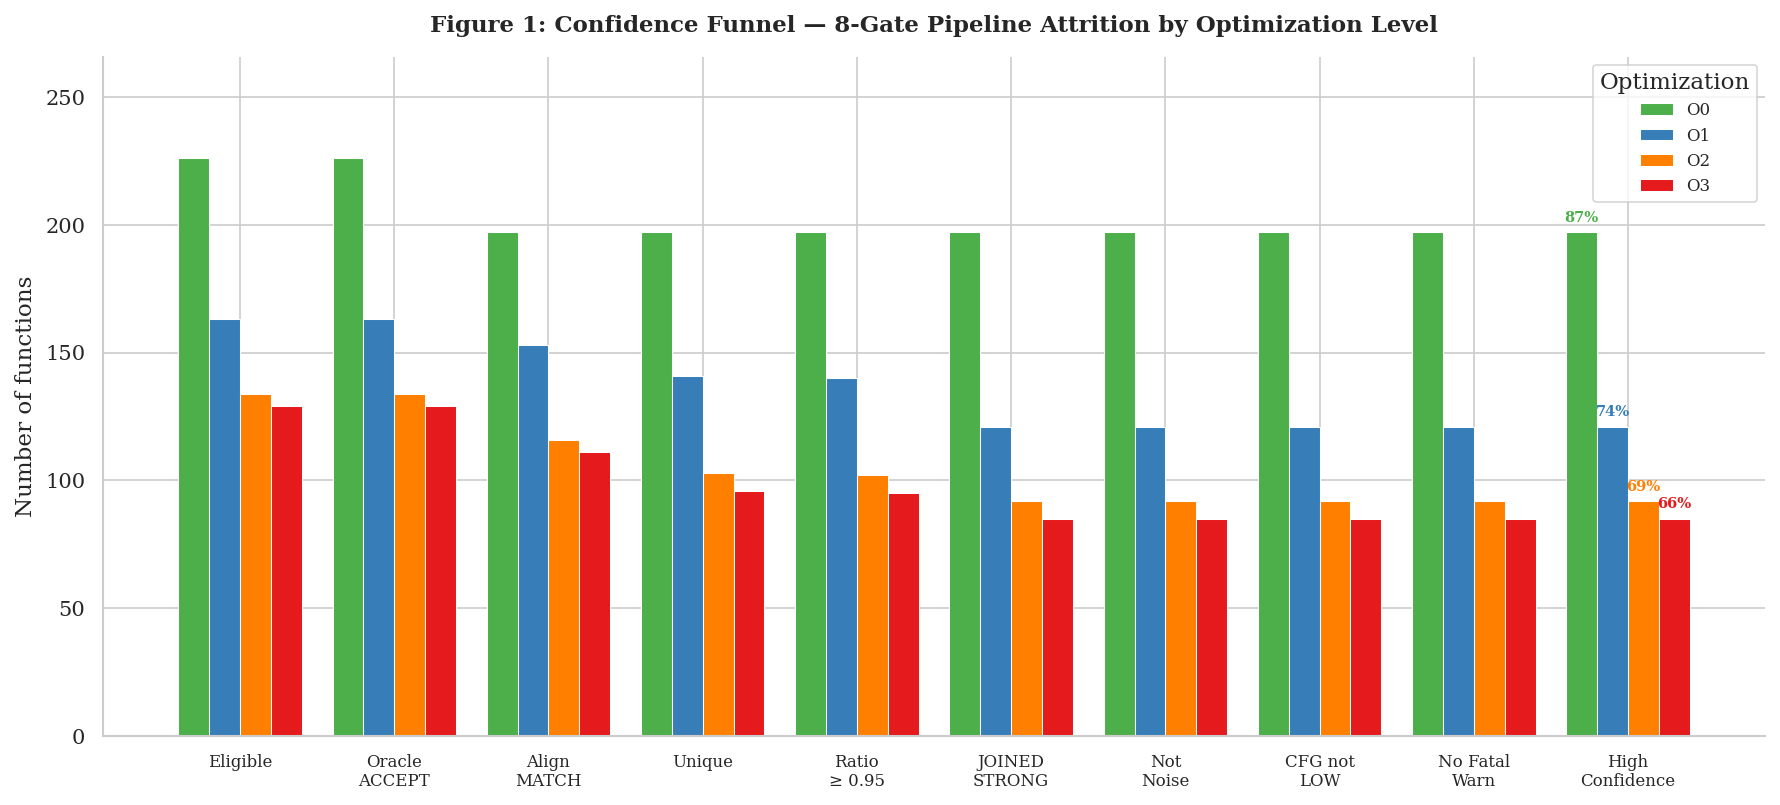


── HC Yield by Optimization Level ──
 Opt  Eligible    HC   Yield
──────────────────────────────
  O0       226   197   87.2%
  O1       163   121   74.2%
  O2       134    92   68.7%
  O3       129    85   65.9%
──────────────────────────────
 All       652   495   75.9%


In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# Figure 1: Confidence Funnel by Optimization Level
# ══════════════════════════════════════════════════════════════════════════════
# Source: gds.reports contains the 8-gate funnel counts per (test_case, opt).

GATE_COLS = [
    ("funnel_n_eligible_for_gold",      "Eligible"),
    ("funnel_n_pass_oracle_accept",     "Oracle\nACCEPT"),
    ("funnel_n_pass_align_match",       "Align\nMATCH"),
    ("funnel_n_pass_align_unique",      "Unique"),
    ("funnel_n_pass_align_ratio",       "Ratio\n≥ 0.95"),
    ("funnel_n_pass_joined_strong",     "JOINED\nSTRONG"),
    ("funnel_n_pass_not_noise",         "Not\nNoise"),
    ("funnel_n_pass_cfg_not_low",       "CFG not\nLOW"),
    ("funnel_n_pass_no_fatal_warnings", "No Fatal\nWarn"),
    ("funnel_n_high_confidence",        "High\nConfidence"),
]

dr = gds.reports
gate_labels = [label for _, label in GATE_COLS]

# ── Grouped bar chart: gates × opt levels ────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5.5))
x = np.arange(len(gate_labels))
n_opts = len(OPT_ORDER)
width = 0.8 / n_opts

for i, opt in enumerate(OPT_ORDER):
    opt_dr = dr[dr["opt"] == opt]
    vals = [int(opt_dr[col].sum()) for col, _ in GATE_COLS]
    bars = ax.bar(
        x + i * width - (n_opts - 1) * width / 2,
        vals, width,
        label=opt, color=OPT_COLORS[opt], edgecolor="white", linewidth=0.5,
    )
    # Annotate HC yield on the final bar
    hc_val  = vals[-1]
    elig_val = vals[0]
    if elig_val > 0:
        yield_pct = hc_val / elig_val * 100
        ax.text(
            x[-1] + i * width - (n_opts - 1) * width / 2,
            hc_val + 3,
            f"{yield_pct:.0f}%",
            ha="center", va="bottom", fontsize=7, fontweight="bold",
            color=OPT_COLORS[opt],
        )

ax.set_xticks(x)
ax.set_xticklabels(gate_labels, fontsize=8)
ax.set_ylabel("Number of functions")
ax.set_title("Figure 1: Confidence Funnel — 8-Gate Pipeline Attrition by Optimization Level",
             fontsize=11, fontweight="bold", pad=12)
ax.legend(title="Optimization", loc="upper right", fontsize=8)
ax.set_ylim(0, ax.get_ylim()[1] * 1.12)

fig.tight_layout()
savefig(fig, "fig01_confidence_funnel")
plt.show()

# ── Key numbers ──────────────────────────────────────────────────────────────
print("\n── HC Yield by Optimization Level ──")
print(f"{'Opt':>4s}  {'Eligible':>8s}  {'HC':>4s}  {'Yield':>6s}")
print("─" * 30)
for opt in OPT_ORDER:
    opt_dr = dr[dr["opt"] == opt]
    elig = int(opt_dr["funnel_n_eligible_for_gold"].sum())
    hc   = int(opt_dr["funnel_n_high_confidence"].sum())
    pct  = hc / elig * 100 if elig > 0 else 0
    print(f"{opt:>4s}  {elig:>8d}  {hc:>4d}  {pct:>5.1f}%")
total_elig = int(dr["funnel_n_eligible_for_gold"].sum())
total_hc   = int(dr["funnel_n_high_confidence"].sum())
print("─" * 30)
print(f"{'All':>4s}  {total_elig:>8d}  {total_hc:>4d}  {total_hc/total_elig*100:>5.1f}%")

In [4]:
# ══════════════════════════════════════════════════════════════════════════════
# §Supplementary: Per-Gate Failure Counts (O0 and O3)
# ══════════════════════════════════════════════════════════════════════════════
# Makes the attribution claims in thesis sections 5.1.2 and 6.1 auditable:
#   - "12.8% yield loss at O0 primarily attributable to alignment-gate failures"
#   - "approximately 34 alignment failures vs 10 decompiler failures at O3"

for opt_show in ["O0", "O3"]:
    opt_data = dr[dr["opt"] == opt_show]
    print(f"\n{'='*60}")
    print(f"Per-Gate Attrition at {opt_show}")
    print(f"{'='*60}")

    prev_col = None
    for col, label in GATE_COLS:
        total = int(opt_data[col].sum())
        if prev_col is not None:
            prev_total = int(opt_data[prev_col].sum())
            lost = prev_total - total
            pct_lost = lost / prev_total * 100 if prev_total > 0 else 0
            print(f"  {label:20s}: {total:4d}  (lost {lost:3d}, {pct_lost:5.1f}% of previous gate)")
        else:
            print(f"  {label:20s}: {total:4d}  (baseline)")
        prev_col = col

    elig = int(opt_data[GATE_COLS[0][0]].sum())
    hc   = int(opt_data[GATE_COLS[-1][0]].sum())
    lost_total = elig - hc

    # Alignment-side gates (2-4): Oracle ACCEPT, Align MATCH, Unique, Ratio
    align_gate_cols = [c for c, _ in GATE_COLS[1:5]]  # gates 2-5 (oracle accept through ratio)
    align_lost = int(opt_data[GATE_COLS[0][0]].sum()) - int(opt_data[GATE_COLS[4][0]].sum())

    # Decompiler-side gate (5): JOINED_STRONG
    decompiler_lost = int(opt_data[GATE_COLS[4][0]].sum()) - int(opt_data[GATE_COLS[5][0]].sum())

    # Quality gates (6-8): Not Noise, CFG, Fatal Warnings
    quality_lost = int(opt_data[GATE_COLS[5][0]].sum()) - int(opt_data[GATE_COLS[-1][0]].sum())

    print(f"\n  Summary: {elig} eligible -> {hc} HC ({lost_total} lost)")
    print(f"    Alignment gates (1-4):  {align_lost} lost")
    print(f"    Decompiler gate (5):    {decompiler_lost} lost")
    print(f"    Quality gates (6-8):    {quality_lost} lost")


Per-Gate Attrition at O0
  Eligible            :  226  (baseline)
  Oracle
ACCEPT       :  226  (lost   0,   0.0% of previous gate)
  Align
MATCH         :  197  (lost  29,  12.8% of previous gate)
  Unique              :  197  (lost   0,   0.0% of previous gate)
  Ratio
≥ 0.95        :  197  (lost   0,   0.0% of previous gate)
  JOINED
STRONG       :  197  (lost   0,   0.0% of previous gate)
  Not
Noise           :  197  (lost   0,   0.0% of previous gate)
  CFG not
LOW         :  197  (lost   0,   0.0% of previous gate)
  No Fatal
Warn       :  197  (lost   0,   0.0% of previous gate)
  High
Confidence     :  197  (lost   0,   0.0% of previous gate)

  Summary: 226 eligible -> 197 HC (29 lost)
    Alignment gates (1-4):  29 lost
    Decompiler gate (5):    0 lost
    Quality gates (6-8):    0 lost

Per-Gate Attrition at O3
  Eligible            :  129  (baseline)
  Oracle
ACCEPT       :  129  (lost   0,   0.0% of previous gate)
  Align
MATCH         :  111  (lost  18,  14.0% of prev

---

## Figure 2 — Model Ranking: Token F1 Distribution

**Finding:** *LLM function naming results are modest.*

Across 7 models, 4 optimization levels, and 3 confidence tiers, the results are
consistently modest. The **median Token F1 is 0.0** for six of seven models (GPT-5.1
has median ≈ 0.286) — for the majority of functions, the LLM's prediction shares zero
tokens with the ground truth. This is not surprising: many functions have short,
domain-specific names (`main`, `init_pool`, `get_state`) that are hard to guess from
decompiled code alone.

**Token F1** is a set-based metric following the convention of DIRTY and SymLM:

$$
P = \frac{|P \cap G|}{|P|}, \quad
R = \frac{|P \cap G|}{|G|}, \quad
F_1 = \frac{2PR}{P + R}
$$

where $P$ and $G$ are **sets** of unique lowercase tokens obtained by splitting
predicted and ground-truth names on camelCase, snake_case, and digit boundaries.
The metric is order-independent and gives partial credit for semantic overlap.

**All-tier aggregates** (across all tiers × all optimization levels):

| Aggregate | Value |
|-----------|-------|
| Mean Token F1 (all-tier) | ≈ 0.25 |
| Median Token F1 | 0.0 (six of seven models) |
| F1 range (all-tier) | 0.18 (GPT-4o mini) – 0.29 (Claude Sonnet 4.5) |
| Exact match rate | 1.9%–7.1% |
| % predictions with F1 > 0 | ≈ 40–55% |

**GOLD-tier only** (high-confidence evaluable subset):

| Aggregate | Value |
|-----------|-------|
| F1 range (GOLD-only) | 0.20 (GPT-4o mini) – 0.32 (Claude Sonnet 4.5) |

> **Note:** The thesis §5.2.1 states metrics are from the GOLD tier unless
> otherwise noted. The model ranking box plot below uses **all tiers** combined.
> GOLD-only values are higher because lower-confidence tiers contain harder or
> less well-aligned functions.

── All-Tier Model Ranking ──


,Model,n,F1 mean,95% CI,F1 median,% non-zero,EM%
0,Claude Sonnet 4.5,692,0.291598,"[0.267, 0.317]",0.000000,49.710983,7.080925
1,GPT-5.1,692,0.265782,"[0.245, 0.287]",0.285714,54.190751,2.745665
2,DeepSeek R1,685,0.263916,"[0.240, 0.288]",0.000000,48.321168,5.985401
3,Qwen3 Coder,692,0.246229,"[0.223, 0.270]",0.000000,44.219653,4.479769
4,DeepSeek V3,692,0.226989,"[0.206, 0.248]",0.000000,44.942197,1.878613
5,Llama-3.1 70B,692,0.221780,"[0.200, 0.244]",0.000000,41.907514,3.034682
6,GPT-4o mini,692,0.177312,"[0.158, 0.197]",0.000000,35.838150,3.034682



── GOLD-Tier Model Ranking (thesis §5.2.1 primary) ──


,Model,n,F1 mean,95% CI,F1 median,% non-zero,EM%
0,Claude Sonnet 4.5,494,0.297484,"[0.267, 0.328]",0.000000,48.380567,8.299595
1,GPT-5.1,494,0.272518,"[0.248, 0.299]",0.285714,54.858300,1.619433
2,DeepSeek R1,487,0.261453,"[0.233, 0.291]",0.000000,46.817248,6.365503
3,Qwen3 Coder,494,0.241758,"[0.214, 0.271]",0.000000,41.295547,5.263158
4,Llama-3.1 70B,494,0.219163,"[0.193, 0.245]",0.000000,39.676113,3.441296
5,DeepSeek V3,494,0.215857,"[0.191, 0.241]",0.000000,41.700405,1.619433
6,GPT-4o mini,494,0.176383,"[0.152, 0.202]",0.000000,32.995951,3.643725



⚠  GOLD-only vs all-tier discrepancy:
   All-tier F1 range: 0.177 – 0.292
   GOLD-only F1 range: 0.176 – 0.297
   Thesis §5.2.1 claims GOLD-tier. Ensure cited numbers match GOLD-only values.
  → saved fig02_model_ranking.{pdf,png}


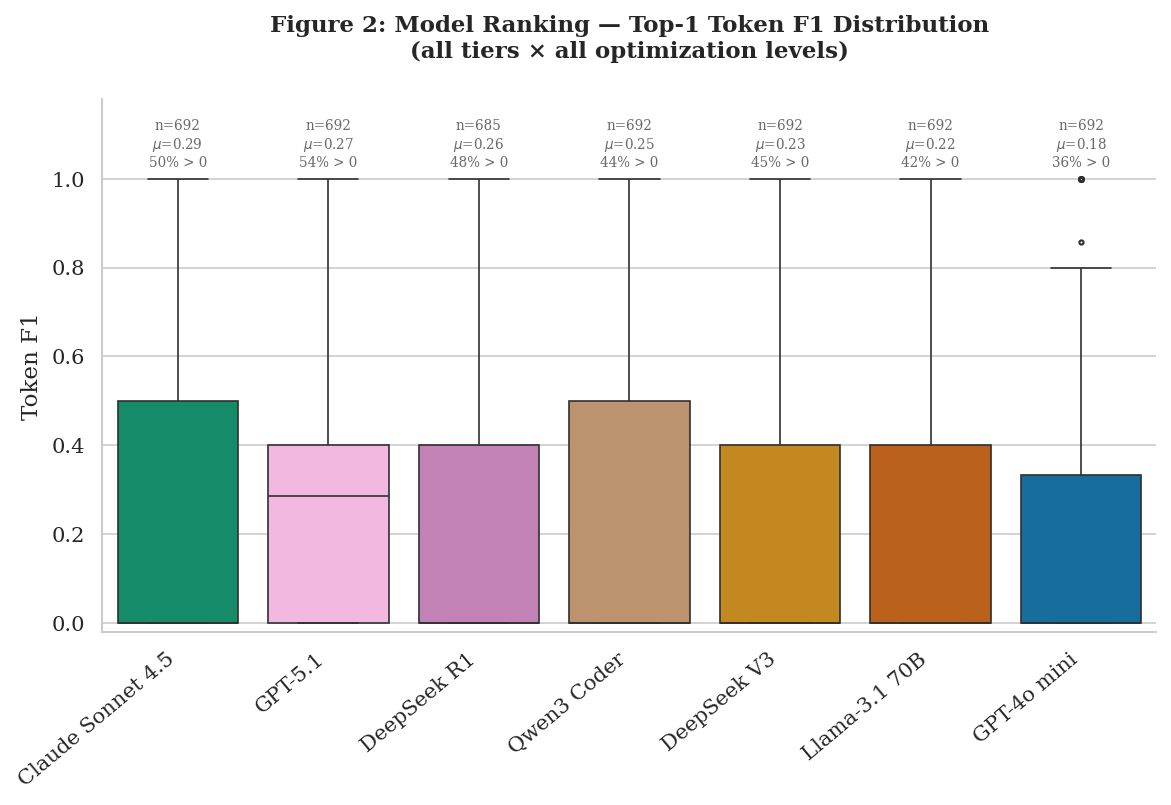

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# Figure 2: Model Ranking — Top-1 Token F1 Box Plot
# ══════════════════════════════════════════════════════════════════════════════

# ── Build ranking table with bootstrap CIs (ALL TIERS) ───────────────────────
rank_rows = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1  = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    pct_nonzero  = (f1 > 0).mean() * 100

    rank_rows.append({
        "Model":       label,
        "n":           len(f1),
        "F1 mean":     f1.mean(),
        "95% CI":      f"[{ci_lo:.3f}, {ci_hi:.3f}]",
        "F1 median":   f1.median(),
        "% non-zero":  pct_nonzero,
        "EM%":         mdf["exact_match"].mean() * 100,
    })

df_rank = pd.DataFrame(rank_rows).sort_values("F1 mean", ascending=False)
print("── All-Tier Model Ranking ──")
display(df_rank.reset_index(drop=True))

# ── GOLD-only ranking table (matches thesis §5.2.1 claim) ───────────────────
df_gold = df[df["tier"] == "GOLD"]
gold_rows = []
for label in sorted(df_gold["model_label"].unique()):
    mdf = df_gold[df_gold["model_label"] == label]
    f1  = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    pct_nonzero  = (f1 > 0).mean() * 100

    gold_rows.append({
        "Model":       label,
        "n":           len(f1),
        "F1 mean":     f1.mean(),
        "95% CI":      f"[{ci_lo:.3f}, {ci_hi:.3f}]",
        "F1 median":   f1.median(),
        "% non-zero":  pct_nonzero,
        "EM%":         mdf["exact_match"].mean() * 100,
    })

df_rank_gold = pd.DataFrame(gold_rows).sort_values("F1 mean", ascending=False)
print("\n── GOLD-Tier Model Ranking (thesis §5.2.1 primary) ──")
display(df_rank_gold.reset_index(drop=True))

# ── Tier discrepancy note ────────────────────────────────────────────────────
print("\n⚠  GOLD-only vs all-tier discrepancy:")
print(f"   All-tier F1 range: {df_rank['F1 mean'].min():.3f} – {df_rank['F1 mean'].max():.3f}")
print(f"   GOLD-only F1 range: {df_rank_gold['F1 mean'].min():.3f} – {df_rank_gold['F1 mean'].max():.3f}")
print("   Thesis §5.2.1 claims GOLD-tier. Ensure cited numbers match GOLD-only values.")

# ── Figure: single-panel box plot (top-1 Token F1, ALL TIERS) ────────────────
model_order = df_rank["Model"].tolist()

fig, ax = plt.subplots(figsize=(8, 5.5))

sns.boxplot(
    data=df, x="model_label", y="token_f1", order=model_order,
    palette=MODEL_PALETTE, ax=ax, fliersize=2, linewidth=0.8,
)
ax.set_title("Figure 2: Model Ranking — Top-1 Token F1 Distribution\n"
             "(all tiers × all optimization levels)",
             fontsize=11, fontweight="bold", pad=20)
ax.set_xlabel("")
ax.set_ylabel("Token F1")
ax.set_ylim(-0.02, 1.18)
ax.tick_params(axis="x", rotation=40)
for tick in ax.get_xticklabels():
    tick.set_ha("right")

# Annotate each box: sample size, mean, % non-zero
for i, label in enumerate(model_order):
    sub = df.loc[df["model_label"] == label, "token_f1"].dropna()
    mu  = sub.mean()
    pnz = (sub > 0).mean() * 100
    ax.annotate(
        f"n={len(sub)}\n$\\mu$={mu:.2f}\n{pnz:.0f}% > 0",
        xy=(i, 1.02), fontsize=6.5, ha="center", va="bottom",
        color="dimgrey",
    )

fig.tight_layout()
savefig(fig, "fig02_model_ranking")
plt.show()

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
# §2  Paired Cohort Construction (required for Figure 3)
# ══════════════════════════════════════════════════════════════════════════════
# For each model, find functions (stable_key) present at all 4 opt levels.
# Convention: positive delta = degradation (O0 was better than O3).
#
# Cross-tier design: a function that is GOLD at O0 but SILVER at O3 IS included.
# This is valid because token_f1 compares against the same ground_truth_name
# regardless of tier — tier reflects DWARF-alignment confidence, not a different
# ground truth.

paired_data: Dict[str, pd.DataFrame] = {}

for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label].copy()
    # Exclude NaN / sentinel / empty stable keys
    mdf = mdf[mdf["stable_key"].notna()]
    mdf = mdf[mdf["stable_key"].str.len() > 0]
    mdf = mdf[~mdf["stable_key"].str.startswith("_unstable")]

    keys_per_opt = mdf.groupby("opt")["stable_key"].apply(set)
    if not set(OPT_ORDER).issubset(keys_per_opt.index):
        continue
    full_keys = set.intersection(*[keys_per_opt[o] for o in OPT_ORDER])
    if not full_keys:
        continue

    cohort = mdf[mdf["stable_key"].isin(full_keys)]
    wide = cohort.pivot_table(
        index="stable_key", columns="opt", values="token_f1", aggfunc="mean"
    ).reindex(columns=OPT_ORDER)
    wide["delta_O0_O3"] = wide["O0"] - wide["O3"]
    wide["delta_O0_O1"] = wide["O0"] - wide["O1"]
    wide["delta_O1_O3"] = wide["O1"] - wide["O3"]
    wide["model"] = label
    paired_data[label] = wide

# ── Cross-tier validity: ground_truth stability ──────────────────────────────
gt_col = "ground_truth" if "ground_truth" in df.columns else "ground_truth_name"
if gt_col in df.columns:
    keyed = df[df["stable_key"].notna() & (df["stable_key"].str.len() > 0)]
    gt_per_key  = keyed.groupby("stable_key")[gt_col].nunique()
    gt_unstable = gt_per_key[gt_per_key > 1]
    print(f"Ground-truth stability: {len(gt_unstable)} / {len(gt_per_key)} keys "
          f"have >1 name across opts ({len(gt_unstable)/max(len(gt_per_key),1)*100:.1f}%)")
    if len(gt_unstable) == 0:
        print("  ✓ All stable keys map to a single ground truth — pairing valid.")

print(f"\nPaired cohort sizes (full O0→O3):")
for label, w in paired_data.items():
    print(f"  {label:25s}: {len(w)} functions")

Ground-truth stability: 0 / 257 keys have >1 name across opts (0.0%)
  ✓ All stable keys map to a single ground truth — pairing valid.

Paired cohort sizes (full O0→O3):
  Claude Sonnet 4.5        : 127 functions
  DeepSeek R1              : 122 functions
  DeepSeek V3              : 126 functions
  GPT-4o mini              : 127 functions
  GPT-5.1                  : 125 functions
  Llama-3.1 70B            : 125 functions
  Qwen3 Coder              : 126 functions


---

## Figure 3 — Optimization Decay Heatmap

**Finding:** *Optimization decay is real but small.*

Paired analysis tracks the **same function** across optimization levels via a stable
cross-optimization key constructed from the DWARF source declaration location
(`DW_AT_decl_file`, `DW_AT_decl_line`, `DW_AT_decl_column`), which is invariant under
optimization. For each function $f_i$ in the paired cohort:

$$
\Delta_i = F_1^{O0}(f_i) - F_1^{O3}(f_i) \quad \text{(positive = degradation)}
$$

**Panel A** shows unpaired mean Token F1 per (model × opt) cell, giving the full
performance landscape. **Panel B** shows the paired mean $\Delta$ with bootstrap 95% CI,
isolating the optimization effect from survivorship confounds.

| Metric | Value |
|--------|-------|
| Mean F1 delta (O0→O3) | −0.006 to +0.033 |
| Wilcoxon p-values | All Holm-corrected p ≥ 0.209 (min: DeepSeek V3 p = 0.210) |
| Rank-biserial \|r\| | 0.05 – 0.15 (small effect) |
| % functions degraded | ≈ 25–35% |
| % functions unchanged | ≈ 50–60% |

The apparent aggregate decay is partly confounded by **survivorship bias**: functions
eliminated by the optimizer at higher levels differ systematically from those that survive.

  → saved fig03_decay_heatmap.{pdf,png}


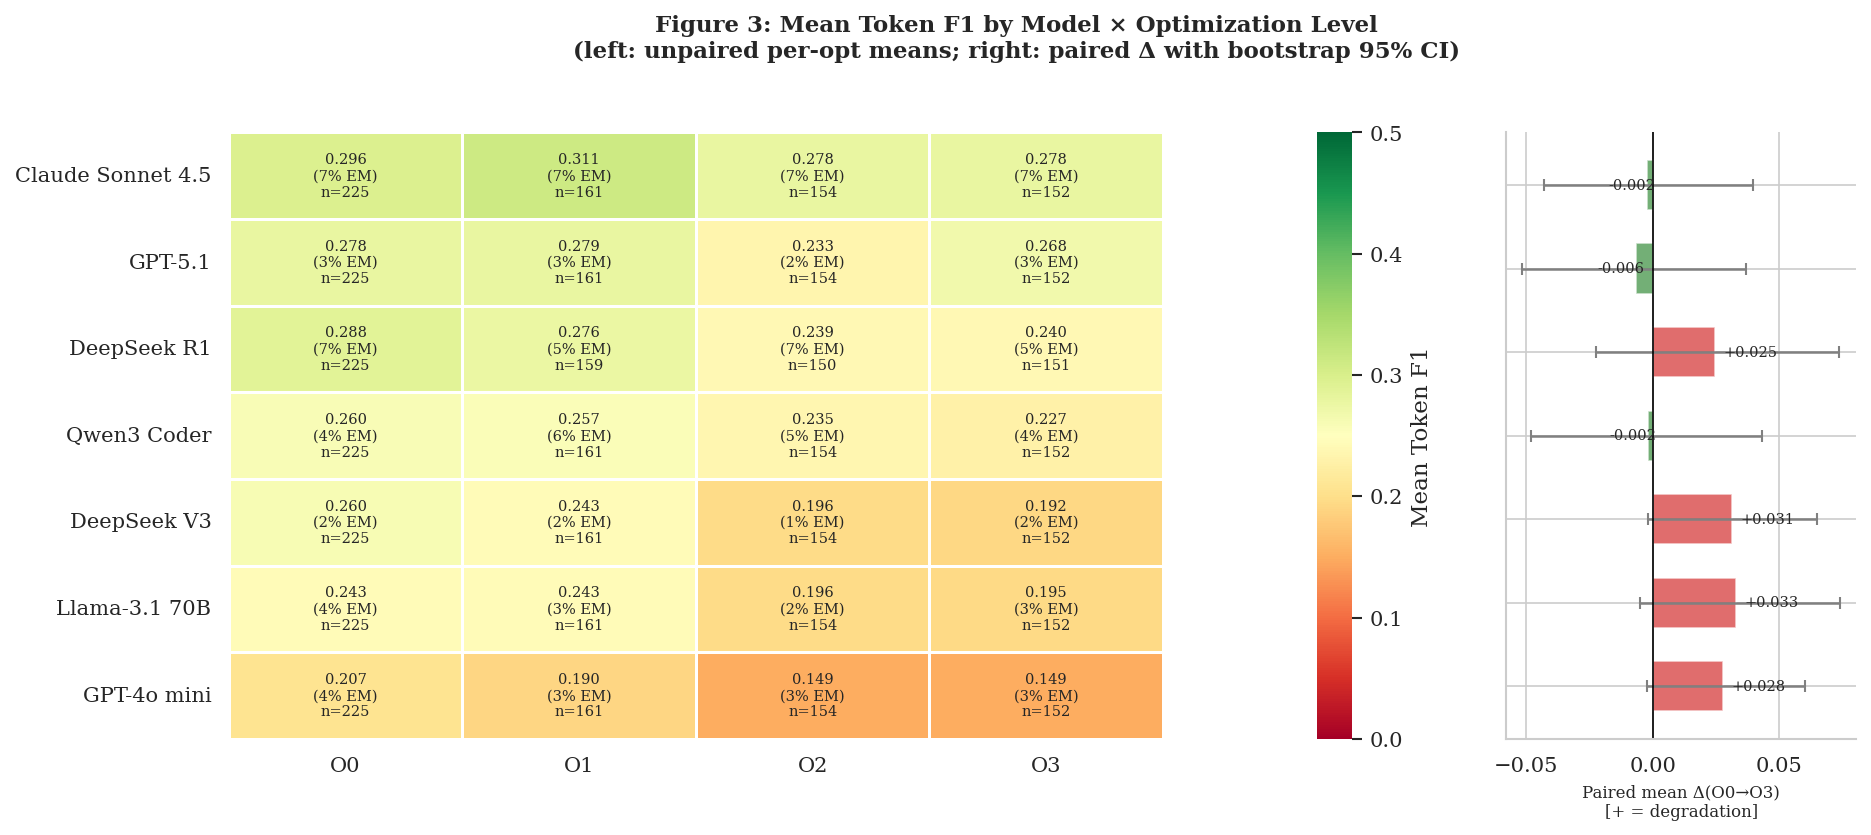


── Wilcoxon Signed-Rank Tests (O0 > O3, one-sided, Holm-corrected) ──


,Model,n_paired,mean_delta,p_wilcoxon,rank_biserial_r,p_holm_adj
0,Claude Sonnet 4.5,127,-0.002137,0.503416,-0.001681,1.000000
1,GPT-5.1,125,-0.006495,0.520587,-0.008296,1.000000
2,DeepSeek R1,122,0.024688,0.141359,0.185859,0.565436
3,Qwen3 Coder,126,-0.001965,0.451967,0.026455,1.000000
4,DeepSeek V3,126,0.031217,0.029933,0.349528,0.209529
5,Llama-3.1 70B,125,0.032800,0.053079,0.361823,0.265395
6,GPT-4o mini,127,0.027709,0.038711,0.403077,0.232267


In [7]:
# ══════════════════════════════════════════════════════════════════════════════
# Figure 3: Mean Token F1 Heatmap + Paired Δ(O0→O3) Bar
# ══════════════════════════════════════════════════════════════════════════════

# ── Panel A data: unpaired mean F1 by (model × opt) ─────────────────────────
hm_rows = []
for label in sorted(df["model_label"].unique()):
    for opt in OPT_ORDER:
        subset = df[(df["model_label"] == label) & (df["opt"] == opt)]
        f1 = subset["token_f1"].dropna()
        em = subset["exact_match"].mean() * 100 if len(subset) > 0 else np.nan
        hm_rows.append({
            "Model": label, "opt": opt,
            "F1": f1.mean() if len(f1) else np.nan,
            "EM%": em, "n": len(f1),
        })

df_hm = pd.DataFrame(hm_rows)
hm_f1 = df_hm.pivot(index="Model", columns="opt", values="F1").reindex(columns=OPT_ORDER)
hm_em = df_hm.pivot(index="Model", columns="opt", values="EM%").reindex(columns=OPT_ORDER)
hm_n  = df_hm.pivot(index="Model", columns="opt", values="n").reindex(columns=OPT_ORDER)

# Order by overall mean F1 (descending)
model_order_hm = hm_f1.mean(axis=1).sort_values(ascending=False).index.tolist()
hm_f1 = hm_f1.reindex(model_order_hm)
hm_em = hm_em.reindex(model_order_hm)
hm_n  = hm_n.reindex(model_order_hm)

# Annotation strings: "F1\n(EM%)\nn=N"
annot = hm_f1.copy().astype(str)
for model in hm_f1.index:
    for col in OPT_ORDER:
        f1_val = hm_f1.loc[model, col]
        em_val = hm_em.loc[model, col]
        n_val  = hm_n.loc[model, col]
        if np.isnan(f1_val):
            annot.loc[model, col] = "—"
        else:
            annot.loc[model, col] = f"{f1_val:.3f}\n({em_val:.0f}% EM)\nn={n_val:.0f}"

# ── Panel B data: paired Δ(O0→O3) per model ─────────────────────────────────
delta_rows = []
for label in model_order_hm:
    if label in paired_data:
        d = paired_data[label]["delta_O0_O3"].dropna()
        mu = d.mean()
        ci_lo, ci_hi = bootstrap_ci(d)
        delta_rows.append({"Model": label, "mean_delta": mu,
                           "ci_lo": ci_lo, "ci_hi": ci_hi})
    else:
        delta_rows.append({"Model": label, "mean_delta": np.nan,
                           "ci_lo": np.nan, "ci_hi": np.nan})
df_delta = pd.DataFrame(delta_rows)

# ── Plot: 2-panel figure (heatmap + paired delta bar) ────────────────────────
fig = plt.figure(figsize=(14, max(3.5, len(hm_f1) * 0.75)))
gs = fig.add_gridspec(1, 3, width_ratios=[4, 0.15, 1.5], wspace=0.35)
ax_hm  = fig.add_subplot(gs[0, 0])
ax_cb  = fig.add_subplot(gs[0, 1])
ax_bar = fig.add_subplot(gs[0, 2])

# Panel A: heatmap
sns.heatmap(
    hm_f1, annot=annot, fmt="", cmap="RdYlGn", vmin=0, vmax=0.5,
    linewidths=0.5, ax=ax_hm, cbar_ax=ax_cb,
    cbar_kws={"label": "Mean Token F1"},
    annot_kws={"fontsize": 7},
)
ax_hm.set_ylabel("")
ax_hm.set_xlabel("")

# Panel B: paired Δ bar with CI
y_pos  = np.arange(len(df_delta))
colors = ["#d32f2f" if v > 0 else "#388e3c" for v in df_delta["mean_delta"]]
xerr_lo = df_delta["mean_delta"] - df_delta["ci_lo"]
xerr_hi = df_delta["ci_hi"] - df_delta["mean_delta"]

ax_bar.barh(
    y_pos, df_delta["mean_delta"], color=colors, alpha=0.7, height=0.6,
    xerr=[xerr_lo.values, xerr_hi.values], ecolor="gray", capsize=3,
)
ax_bar.axvline(0, color="black", linewidth=0.8, linestyle="-")
ax_bar.set_yticks(y_pos)
ax_bar.set_yticklabels([])
ax_bar.invert_yaxis()
ax_bar.set_xlabel("Paired mean Δ(O0→O3)\n[+ = degradation]", fontsize=8)

for i, row in df_delta.iterrows():
    if np.isfinite(row["mean_delta"]):
        ax_bar.annotate(
            f"{row['mean_delta']:+.3f}",
            xy=(row["mean_delta"], i),
            xytext=(4, 0), textcoords="offset points",
            fontsize=7, va="center",
            ha="left" if row["mean_delta"] >= 0 else "right",
        )

fig.suptitle(
    "Figure 3: Mean Token F1 by Model × Optimization Level\n"
    "(left: unpaired per-opt means; right: paired Δ with bootstrap 95% CI)",
    fontsize=11, fontweight="bold", y=1.03,
)
savefig(fig, "fig03_decay_heatmap", bbox_inches="tight")
plt.show()

# ── Statistical tests: Wilcoxon + Holm correction ───────────────────────────
from statsmodels.stats.multitest import multipletests

test_rows = []
p_values_all = []
for label in model_order_hm:
    if label not in paired_data:
        continue
    w = paired_data[label]
    d = w["delta_O0_O3"].dropna()
    x, y = w["O0"].dropna(), w["O3"].dropna()
    common = x.index.intersection(y.index)
    x, y = x.loc[common], y.loc[common]
    try:
        stat_w, p_w = stats.wilcoxon(x, y, alternative="greater")
    except ValueError:
        stat_w, p_w = np.nan, np.nan
    rb = rank_biserial(x.values, y.values)
    p_values_all.append(p_w)
    test_rows.append({
        "Model": label, "n_paired": len(common),
        "mean_delta": d.mean(), "p_wilcoxon": p_w, "rank_biserial_r": rb,
    })

# Holm-Bonferroni correction
if p_values_all:
    _, p_adj, _, _ = multipletests(p_values_all, method="holm")
    for i, row in enumerate(test_rows):
        row["p_holm_adj"] = p_adj[i]

df_tests = pd.DataFrame(test_rows)
print("\n── Wilcoxon Signed-Rank Tests (O0 > O3, one-sided, Holm-corrected) ──")
display(df_tests)

---

## Figure 4 — Tier Transition Matrices

**Finding:** *Function loss through inlining/elimination is the dominant effect.*

Optimization does not merely degrade quality — it fundamentally changes **which functions
are measurable**. The dominant transitions are between "present" and "absent":

| Observation | Numbers |
|-------------|---------|
| Functions at O0 | 220 |
| Functions at O3 | 132 (40% loss) |
| Non-target growth O0→O3 | 181 → 318 |
| Full O0–O3 trajectories | ~58% of all functions |

Each matrix shows how functions move between confidence tiers (GOLD / SILVER / BRONZE)
and into/out of the "absent" state at each adjacent optimization step.

**Stable key construction:** DWARF debug identifiers (`dwarf_function_id`, i.e.,
compilation-unit DIE offsets like `cu0x0:die0x12d`) are **not stable** across
optimization levels — approximately 86% of values shift between O0 and O1.
Instead, the stable cross-optimization key is constructed from source declaration
location:

```
stable_key = test_case | decl_file | decl_line | decl_column | name_norm
```

These come from `DW_AT_decl_file`, `DW_AT_decl_line`, `DW_AT_decl_column` DWARF
attributes, which are invariant under optimization because they reference the
original source line, not the compiled code layout.

  → saved fig04_tier_transitions.{pdf,png}


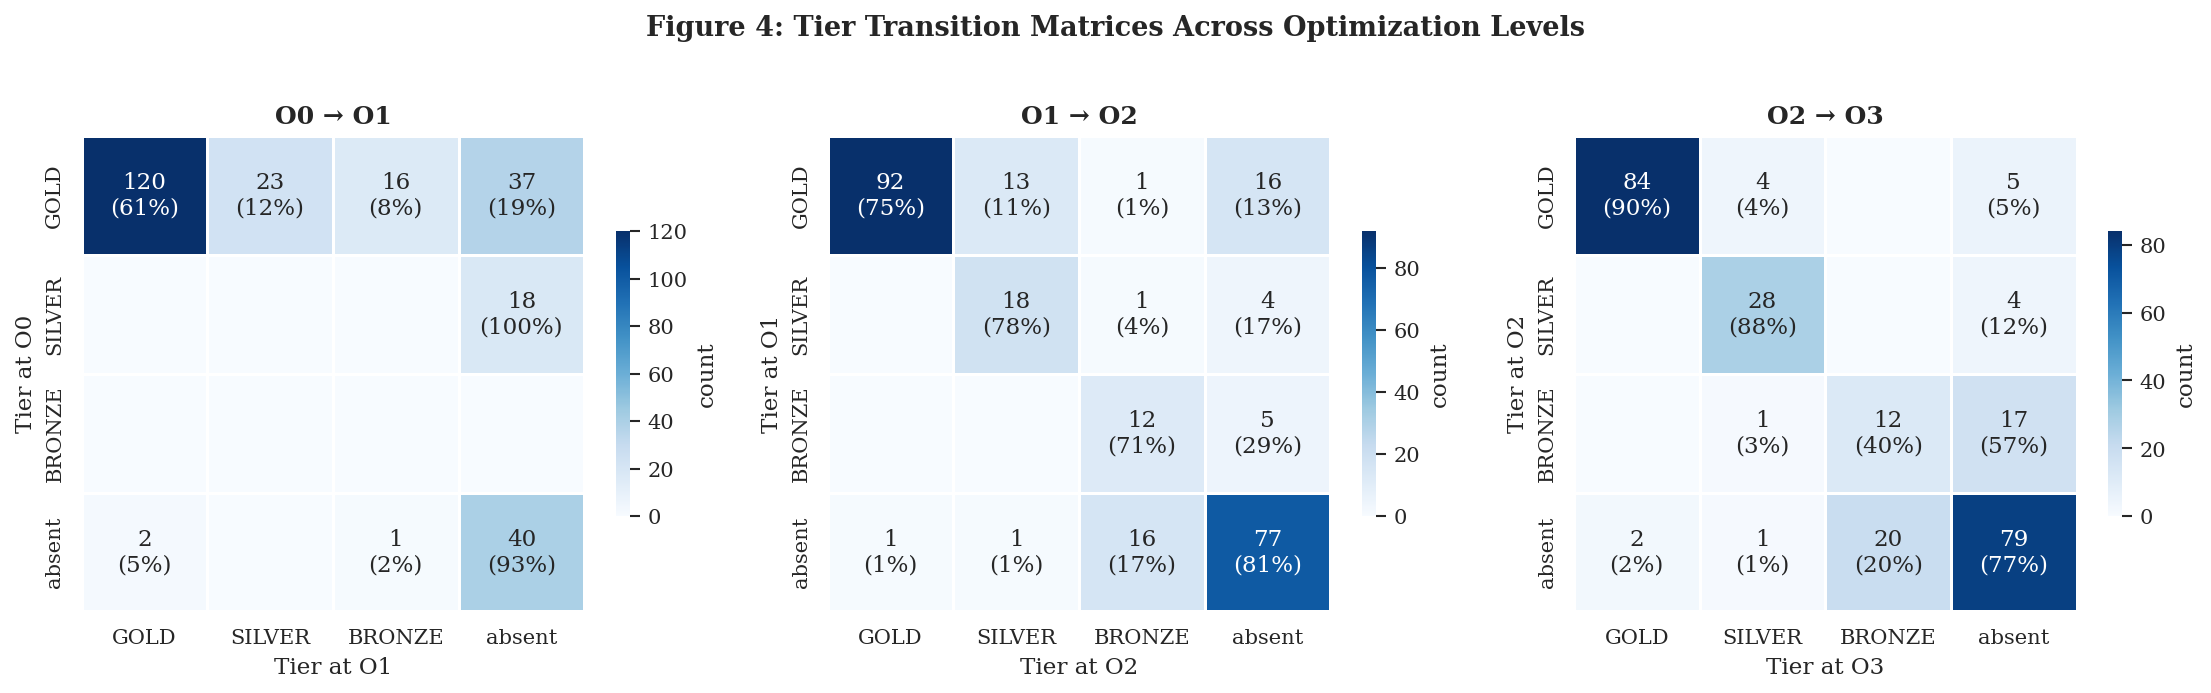


── Transition Summary ──
  O0→O1: 120 stable (75%), 39 tier-hopped, 3 entered, 55 exited
  O1→O2: 122 stable (89%), 15 tier-hopped, 18 entered, 25 exited
  O2→O3: 124 stable (96%), 5 tier-hopped, 23 entered, 26 exited


In [8]:
# ══════════════════════════════════════════════════════════════════════════════
# Figure 4: Tier Transition Matrices
# ══════════════════════════════════════════════════════════════════════════════
# Tier is a pipeline property (not model-dependent). I use the LLM benchmark
# df because it already has stable_key + tier columns. Majority-vote resolves
# the ~0.3% of edge cases with inconsistent tier across models.

# ── Build trajectory table ───────────────────────────────────────────────────
# Majority tier per (stable_key, opt)
tier_majority = (
    df.groupby(["stable_key", "opt"])["tier"]
    .agg(lambda x: x.value_counts().index[0])
)
tier_wide = tier_majority.unstack("opt").reindex(columns=OPT_ORDER)
tier_wide.columns = [f"tier_{o}" for o in OPT_ORDER]

tier_cols = [f"tier_{o}" for o in OPT_ORDER]

# ── Transition matrices (O0→O1, O1→O2, O2→O3) ──────────────────────────────
CATEGORIES = ["GOLD", "SILVER", "BRONZE", "absent"]
opt_steps  = [("O0", "O1"), ("O1", "O2"), ("O2", "O3")]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
trans_tables = {}

for ax, (opt_a, opt_b) in zip(axes, opt_steps):
    col_a = f"tier_{opt_a}"
    col_b = f"tier_{opt_b}"

    tier_a = tier_wide[col_a].fillna("absent")
    tier_b = tier_wide[col_b].fillna("absent")

    ct = pd.crosstab(tier_a, tier_b, dropna=False)
    ct = ct.reindex(index=CATEGORIES, columns=CATEGORIES, fill_value=0)
    trans_tables[(opt_a, opt_b)] = ct

    # Row-normalized for annotation percentages
    row_sums = ct.sum(axis=1)
    ct_pct   = ct.div(row_sums.replace(0, 1), axis=0) * 100

    annot_arr = np.empty_like(ct, dtype=object)
    for i in range(len(CATEGORIES)):
        for j in range(len(CATEGORIES)):
            count = ct.iloc[i, j]
            pct   = ct_pct.iloc[i, j]
            annot_arr[i, j] = f"{count}\n({pct:.0f}%)" if count > 0 else ""

    sns.heatmap(
        ct, annot=annot_arr, fmt="", cmap="Blues",
        linewidths=0.5, linecolor="white",
        cbar_kws={"shrink": 0.6, "label": "count"},
        ax=ax,
    )
    ax.set_title(f"{opt_a} → {opt_b}", fontsize=12, fontweight="bold")
    ax.set_xlabel(f"Tier at {opt_b}")
    ax.set_ylabel(f"Tier at {opt_a}")

fig.suptitle(
    "Figure 4: Tier Transition Matrices Across Optimization Levels",
    fontsize=13, fontweight="bold", y=1.02,
)
fig.tight_layout()
savefig(fig, "fig04_tier_transitions")
plt.show()

# ── Summary statistics ───────────────────────────────────────────────────────
print("\n── Transition Summary ──")
for (opt_a, opt_b), ct in trans_tables.items():
    total_present = ct.loc[
        ct.index != "absent", ct.columns != "absent"
    ].sum().sum()
    on_diag = sum(
        ct.loc[t, t] for t in TIER_ORDER
        if t in ct.index and t in ct.columns
    )
    off_diag = total_present - on_diag
    entered  = ct.loc["absent", ct.columns != "absent"].sum() if "absent" in ct.index else 0
    exited   = ct.loc[ct.index != "absent", "absent"].sum() if "absent" in ct.columns else 0
    print(f"  {opt_a}→{opt_b}: {on_diag} stable "
          f"({on_diag/max(total_present,1)*100:.0f}%), "
          f"{off_diag} tier-hopped, {entered} entered, {exited} exited")

---

## Figure 5 — Top-K Uplift ECDF

**Finding:** *Top-3 candidate shortlists help meaningfully.*

The top-3 structured output format (JSON with ranked candidates) consistently
improves over single-name prediction. For 13.6%–26.7% of functions (model-dependent),
the best candidate was **not** the model's top-1 prediction, suggesting partial
knowledge that cannot always be correctly self-ranked.

$$
\text{uplift}_i = F_1^{\text{top-k}}(f_i) - F_1^{\text{top-1}}(f_i)
$$

where $F_1^{\text{top-k}} = \max_{j \in 1..k} F_1(c_j, g)$ — the oracle-best
Token F1 across all $k$ candidates. Because top-k includes top-1 by construction,
uplift is always $\geq 0$.

> **Note:** This is an **oracle best-of-k** metric. It measures the theoretical
> ceiling of a human analyst reviewing a shortlist, not an automated selection
> mechanism. In practice, a human analyst or automated re-ranker would select
> from the candidates.

| Metric | Value |
|--------|-------|
| % functions with uplift > 0 | 13.6%–26.7% (Qwen3 Coder to DeepSeek R1) |
| Mean uplift | 0.056–0.116 |
| Top-K exact match rate | 1.5–2× the top-1 rate |

Top-K Uplift Summary:


,Model,n,n improved,% improved,Mean uplift,95% CI,Cohen's d,p (Holm-adj)
0,Claude Sonnet 4.5,692,175,25.3%,0.115531,"[0.0981, 0.1339]",0.484251,3.374094e-30
1,DeepSeek R1,685,183,26.7%,0.093913,"[0.0798, 0.1088]",0.486705,2.235016e-31
2,GPT-5.1,692,182,26.3%,0.079600,"[0.0673, 0.0921]",0.476924,3.155853e-31
3,Llama-3.1 70B,692,115,16.6%,0.075358,"[0.0623, 0.0892]",0.409413,1.072119e-20
4,DeepSeek V3,692,122,17.6%,0.074002,"[0.0601, 0.0887]",0.389003,1.454222e-21
5,Qwen3 Coder,692,94,13.6%,0.062538,"[0.0500, 0.0758]",0.357628,1.241974e-17
6,GPT-4o mini,692,102,14.7%,0.056193,"[0.0451, 0.0680]",0.368670,1.049041e-18


  → saved fig05_topk_uplift_ecdf.{pdf,png}


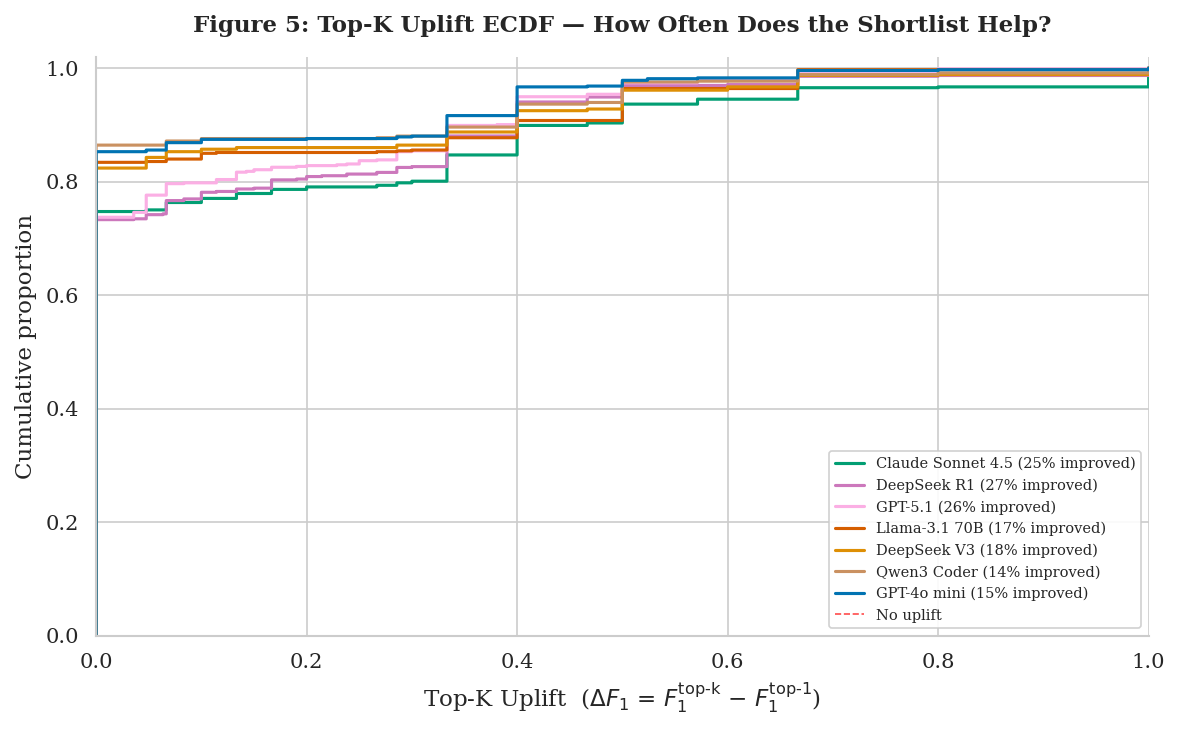

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# Figure 5: Top-K Uplift ECDF
# ══════════════════════════════════════════════════════════════════════════════

topk_df = df.dropna(subset=["token_f1_topk", "topk_uplift"]).copy()

# ── Sanity checks ────────────────────────────────────────────────────────────
n_neg = (topk_df["topk_uplift"] < -1e-9).sum()
assert n_neg == 0, f"Found {n_neg} negative uplift values — upstream bug!"
assert topk_df["topk_uplift"].max() <= 1.0 + 1e-9, "Uplift exceeds [0,1] bound"

# ── Per-model uplift summary with bootstrap CIs and Cohen's d ────────────────
from statsmodels.stats.multitest import multipletests

uplift_rows = []
p_values_topk = []

for label in sorted(topk_df["model_label"].unique()):
    mdf    = topk_df[topk_df["model_label"] == label]
    uplift = mdf["topk_uplift"]
    f1_top1 = mdf["token_f1"]
    f1_topk = mdf["token_f1_topk"]

    n = len(uplift)
    n_improved  = (uplift > 0).sum()
    pct_improved = n_improved / n * 100
    mean_uplift  = uplift.mean()
    ci_lo, ci_hi = bootstrap_ci(uplift)

    # Cohen's d (paired)
    sd_uplift = uplift.std(ddof=1)
    cohens_d  = mean_uplift / sd_uplift if sd_uplift > 0 else np.nan

    # Wilcoxon (quasi-trivial since topk ≥ top1 by construction)
    try:
        _, p_w = stats.wilcoxon(f1_topk, f1_top1, alternative="greater")
    except ValueError:
        p_w = np.nan
    p_values_topk.append(p_w)

    uplift_rows.append({
        "Model":         label,
        "n":             n,
        "n improved":    n_improved,
        "% improved":    f"{pct_improved:.1f}%",
        "Mean uplift":   mean_uplift,
        "95% CI":        f"[{ci_lo:.4f}, {ci_hi:.4f}]",
        "Cohen's d":     cohens_d,
    })

# Holm-Bonferroni correction
if p_values_topk:
    rejected, p_adj, _, _ = multipletests(p_values_topk, method="holm")
    for i, row in enumerate(uplift_rows):
        row["p (Holm-adj)"] = p_adj[i]

df_uplift = pd.DataFrame(uplift_rows).sort_values("Mean uplift", ascending=False)
print("Top-K Uplift Summary:")
display(df_uplift.reset_index(drop=True))

# ── ECDF plot ────────────────────────────────────────────────────────────────
model_order_uplift = df_uplift["Model"].tolist()

fig, ax = plt.subplots(figsize=(8, 5))

for label in model_order_uplift:
    uplift = topk_df.loc[topk_df["model_label"] == label, "topk_uplift"].sort_values()
    ecdf_y = np.arange(1, len(uplift) + 1) / len(uplift)
    pct = (uplift > 0).mean() * 100
    ax.step(
        uplift, ecdf_y, where="post",
        label=f"{label} ({pct:.0f}% improved)",
        color=MODEL_PALETTE.get(label), linewidth=1.5,
    )

ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.7, label="No uplift")
ax.set_xlabel("Top-K Uplift  ($\\Delta F_1$ = $F_1^{\\mathrm{top\\text{-}k}}$ − $F_1^{\\mathrm{top\\text{-}1}}$)")
ax.set_ylabel("Cumulative proportion")
ax.set_title(
    "Figure 5: Top-K Uplift ECDF — How Often Does the Shortlist Help?",
    fontsize=11, fontweight="bold", pad=12,
)
ax.legend(loc="lower right", fontsize=7, framealpha=0.9)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.02)

fig.tight_layout()
savefig(fig, "fig05_topk_uplift_ecdf")
plt.show()

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# §Supplementary: Kendall's W (Cross-Model Concordance)
# ══════════════════════════════════════════════════════════════════════════════
# Previously computed only in scripts/TEST_function_trajectories.ipynb.
# Added here for traceability: all primary thesis numbers in one notebook.

def kendall_w(rankings_matrix):
    """Kendall's W (coefficient of concordance) from a (k_judges x n_items) matrix."""
    k, n = rankings_matrix.shape
    if n < 2 or k < 2:
        return np.nan
    ranked = np.apply_along_axis(stats.rankdata, 1, rankings_matrix)
    col_sums = ranked.sum(axis=0)
    mean_sum = col_sums.mean()
    ss = np.sum((col_sums - mean_sum) ** 2)
    w = 12 * ss / (k**2 * (n**3 - n))
    return w

# ── Build trajectory data from df ────────────────────────────────────────────
models_w = sorted(df["model_label"].unique())

keyed_w = df[df["stable_key"].notna() & (df["stable_key"].str.len() > 0)].copy()
keyed_w = keyed_w[~keyed_w["stable_key"].str.startswith("_unstable")]
keys_per_opt_w = keyed_w.groupby("opt")["stable_key"].apply(set)

if set(OPT_ORDER).issubset(keys_per_opt_w.index):
    full_keys_w = set.intersection(*[keys_per_opt_w[o] for o in OPT_ORDER])
else:
    full_keys_w = set()

print(f"Functions with full O0-O3 coverage: {len(full_keys_w)}")

# ── Build tier trajectory: majority-voted tier per (stable_key, opt) ─────────
tier_by_key_opt_w = (
    keyed_w.groupby(["stable_key", "opt"])["tier"]
    .agg(lambda x: x.value_counts().index[0])
    .unstack("opt")
    .reindex(columns=OPT_ORDER)
)

def count_tier_changes_w(row):
    tiers = [row.get(o) for o in OPT_ORDER]
    tiers = [t for t in tiers if pd.notna(t)]
    return sum(1 for a, b in zip(tiers, tiers[1:]) if a != b)

tier_changes_w = tier_by_key_opt_w.apply(count_tier_changes_w, axis=1)

# ── Compute W for stable and hopping groups ──────────────────────────────────
w_results = []
for group_label, mask_func in [
    ("stable",  lambda tc: tc == 0),
    ("hopping", lambda tc: tc > 0),
]:
    group_keys = [k for k in full_keys_w if mask_func(tier_changes_w.get(k, -1))]
    if len(group_keys) < 5:
        print(f"  {group_label}: skipped (only {len(group_keys)} functions)")
        continue

    rank_matrix = []
    for model in models_w:
        mean_f1s = []
        for sk in group_keys:
            sk_data = keyed_w[
                (keyed_w["stable_key"] == sk) & (keyed_w["model_label"] == model)
            ]["token_f1"]
            mean_f1s.append(sk_data.mean())
        rank_matrix.append(mean_f1s)

    rank_matrix = np.array(rank_matrix)
    valid_cols = ~np.isnan(rank_matrix).any(axis=0)
    rank_matrix = rank_matrix[:, valid_cols]

    w = kendall_w(rank_matrix)
    n_valid = rank_matrix.shape[1]

    w_results.append({
        "Group": group_label,
        "n_functions": n_valid,
        "n_models": len(models_w),
        "Kendall_W": round(w, 4),
        "Interpretation": "moderate" if w < 0.7 else "strong",
    })
    print(f"  {group_label:8s}: W = {w:.4f}  (n={n_valid} functions, {len(models_w)} models)")

df_kendall = pd.DataFrame(w_results)
display(df_kendall)

print("\nThesis reference: Kendall's W = 0.66-0.77")
print("Ranking variable: mean F1 across all opt levels per function.")
print("Stable = tier never changes O0->O3; Hopping = tier changes >= 1 time.")

Functions with full O0-O3 coverage: 128
  stable  : W = 0.6569  (n=83 functions, 7 models)
  hopping : W = 0.7655  (n=45 functions, 7 models)


,Group,n_functions,n_models,Kendall_W,Interpretation
0,stable,83,7,0.6569,moderate
1,hopping,45,7,0.7655,strong



Thesis reference: Kendall's W = 0.66-0.77
Ranking variable: mean F1 across all opt levels per function.
Stable = tier never changes O0->O3; Hopping = tier changes >= 1 time.


---

## Summary & Key Statistics

### The Story in Five Numbers

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Mean Token F1 (all-tier)** | ≈ 0.25 | LLMs recover roughly one quarter of the semantic content of function names |
| **Exact Match rate** | 1.9–7.1% | Only 1 in 14–53 predictions match the original name exactly |
| **HC Yield O0 → O3** | 87% → 66% | The pipeline loses a third of its high-confidence ground truth at O3 |
| **Paired F1 decay** | −0.006 to +0.033 | Per-function degradation not significant (all Holm p ≥ 0.209) |
| **Top-K uplift** | 13.6%–26.7% improved | Offering 3 candidates instead of 1 helps meaningfully |

### Five Defensible Thesis Claims

1. **"Constructing high-confidence ground truth for RE evaluation requires aggressive multi-stage
   filtering."** HC yield decreases from 87% at O0 to 66% at O3.

2. **"LLMs achieve modest function-naming accuracy on decompiled code."** Mean Token F1 ≈ 0.25;
   median = 0.0 for six of seven models indicates majority of predictions share no tokens with ground truth.

3. **"Paired analysis reveals no robust evidence of systematic optimization-induced
   decay."** Mean delta −0.006 to +0.033, all Holm-corrected p ≥ 0.209.

4. **"All seven evaluated models produce broadly similar naming accuracy."** Mean F1 ranges
   0.18–0.29 (all-tier) / 0.20–0.32 (GOLD-only); Kendall's W = 0.66–0.77.

5. **"Requesting multiple ranked candidates (k=3) improves both Token F1 and exact match rates."**
   For 13.6%–26.7% of functions, the best candidate was not the top-1 prediction.

In [11]:
# ══════════════════════════════════════════════════════════════════════════════
# §Final  Per-Model Summary & CSV Export
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 72)
print("THESIS BENCHMARK SUMMARY")
print("=" * 72)
print(f"Total scored predictions : {len(df):,}")
print(f"Models                   : {df['model_label'].nunique()}")
print(f"Test cases               : {df['test_case'].nunique()}")
print(f"Experiments              : {df['experiment_id'].nunique()}")
print()

for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1  = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    em_pct = mdf["exact_match"].mean() * 100

    decay_str = "—"
    if label in paired_data:
        d = paired_data[label]["delta_O0_O3"]
        d_ci_lo, d_ci_hi = bootstrap_ci(d)
        n_deg = (d > 0).sum()
        decay_str = (f"mean Δ = {d.mean():+.3f} [{d_ci_lo:.3f}, {d_ci_hi:.3f}], "
                     f"degraded {n_deg}/{len(d)} ({n_deg/len(d)*100:.0f}%)")

    topk_str = "—"
    topk_sub = mdf["topk_uplift"].dropna()
    if len(topk_sub) > 0:
        topk_str = f"{(topk_sub > 0).mean()*100:.0f}% improved, mean = {topk_sub.mean():.3f}"

    print(f"  {label}:")
    print(f"    F1 = {f1.mean():.3f} [{ci_lo:.3f}, {ci_hi:.3f}]  EM = {em_pct:.1f}%")
    print(f"    Decay  (paired O0→O3): {decay_str}")
    print(f"    Top-K  uplift:         {topk_str}")
    print()

# ── CSV export ───────────────────────────────────────────────────────────────
# 1) Full scored results
export_cols = [
    "experiment_id", "model_label", "tier", "opt", "ground_truth",
    "token_f1", "exact_match", "is_trivial", "parse_ok",
    "token_f1_topk", "exact_match_topk", "topk_uplift", "best_candidate_index",
]
df[export_cols].to_csv(TABLE_DIR / "full_scores.csv", index=False)
print(f"✓ full_scores.csv        → {len(df):,} rows")

# 2) Model summary
summary_rows = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1  = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    summary_rows.append({
        "model":           label,
        "n":               len(mdf),
        "mean_f1":         f1.mean(),
        "ci_lo":           ci_lo,
        "ci_hi":           ci_hi,
        "em_pct":          mdf["exact_match"].mean() * 100,
        "topk_uplift_pct": (mdf["topk_uplift"].dropna() > 0).mean() * 100,
    })
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(TABLE_DIR / "model_summary.csv", index=False)
print(f"✓ model_summary.csv      → {len(df_summary)} rows")

# 3) Decay tests
df_tests.to_csv(TABLE_DIR / "decay_tests.csv", index=False)
print(f"✓ decay_tests.csv        → {len(df_tests)} rows")

print(f"\nAll CSVs saved to {TABLE_DIR}")

THESIS BENCHMARK SUMMARY
Total scored predictions : 4,837
Models                   : 7
Test cases               : 15
Experiments              : 77

  Claude Sonnet 4.5:
    F1 = 0.292 [0.267, 0.317]  EM = 7.1%
    Decay  (paired O0→O3): mean Δ = -0.002 [-0.043, 0.040], degraded 17/127 (13%)
    Top-K  uplift:         25% improved, mean = 0.116

  DeepSeek R1:
    F1 = 0.264 [0.240, 0.288]  EM = 6.0%
    Decay  (paired O0→O3): mean Δ = +0.025 [-0.022, 0.074], degraded 25/122 (20%)
    Top-K  uplift:         27% improved, mean = 0.094

  DeepSeek V3:
    F1 = 0.227 [0.206, 0.248]  EM = 1.9%
    Decay  (paired O0→O3): mean Δ = +0.031 [-0.002, 0.065], degraded 25/126 (20%)
    Top-K  uplift:         18% improved, mean = 0.074

  GPT-4o mini:
    F1 = 0.177 [0.158, 0.197]  EM = 3.0%
    Decay  (paired O0→O3): mean Δ = +0.028 [-0.002, 0.060], degraded 16/127 (13%)
    Top-K  uplift:         15% improved, mean = 0.056

  GPT-5.1:
    F1 = 0.266 [0.245, 0.287]  EM = 2.7%
    Decay  (paired O0→

---

## Limitations

These results should be interpreted within the following scope constraints:

1. **Synthetic corpus.** The 15 test cases are researcher-authored C programs, with intentional coding practices to trigger compiler "weirdness", not
   production binaries. External validity is limited.

2. **Single compiler, single decompiler.** Results are specific to GCC (x86-64,
   `-std=c11`) and Ghidra 12.0. Different toolchains would produce different outputs.

3. **Small function corpus.** 220 functions at O0, 132 at O3. The BRONZE tier
   has 6–17 functions depending on optimization level.

4. **Token F1 is a weak metric.** Set-based, order-independent, no weighting.
   Cannot distinguish semantic similarity without lexical overlap
   (`calculate_sum` vs `compute_total`).

5. **BRONZE O0 gap.** BRONZE tier has no O0 data (at O0, most functions pass all
   gates and are classified as GOLD). Cross-tier comparisons involving O0 are
   fundamentally incomplete.

6. **No practical utility threshold.** A mean F1 of 0.25 might be useless for
   automated renaming but valuable as input to a human analyst's workflow.

---
